In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../../..'))

if module_path not in sys.path:
    print(f"Adding [{module_path}] to sys.path")
    sys.path.append(module_path)

In [2]:
import logging
logging.basicConfig(level=logging.WARN)

from copy import copy
import pathlib

import gym
# noinspection PyUnresolvedReferences
import gym_corridor

from lcs.metrics import population_metrics
from lcs.strategies.action_selection import EpsilonGreedy, KnowledgeArray, ActionDelay

from utils.corridorx import calculate_knowledge
from utils.experiments import avg_experiments
from utils.plotting import COLORS

from matplotlib import rc
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick

rc('pdf', **{'fonttype': 42})
rc('ps', **{'fonttype': 42})
rc('font',**{'family':'sans-serif', 'sans-serif': ['DejaVu Sans'],'size': 14})

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # comment if you don't have high-res display

## Experiment settings

In [3]:
from notebooks import get_from_cache_or_run

cache_prefix = f'{pathlib.Path().absolute()}/cache/'
cache_prefix

'/home/arc/Projects/pwr/pyalcs-experiments/notebooks/publications/2020_investigating-exploration-techniques-for-acs-in-discretized-real-valued-environments/cache/'

In [5]:
experiments = 10

explore_trials = 60
exploit_trials = 20

## Environment

In [6]:
class CorridorObservationWrapper(gym.ObservationWrapper):
    def observation(self, observation):
        return observation,

corridor_length = 20  # 20/40/100

ENV_NAME = f'corridor-{corridor_length}-v0'
env = CorridorObservationWrapper(gym.make(ENV_NAME))

In [7]:
def corridor_metrics(agent, env):
    pop = agent.population
    metrics = {
        'knowledge': calculate_knowledge(pop, env)
    }
    metrics.update(population_metrics(pop, env))
    return metrics

In [8]:
base_params = {
    "classifier_length": 1,
    "number_of_possible_actions": 2,
    "epsilon": 0.8,
    "beta": 0.2,
    "gamma": 0.95,
    "initial_q": 0.5,
    "theta_exp": 50,
    "theta_ga": 50,
    "do_ga": True,
    "mu": 0.03,
    "u_max": 1,
    "metrics_trial_frequency": 1,
    "user_metrics_collector_fcn": corridor_metrics
}

### Epsilon Greedy (baseline)

In [9]:
%%time

epsilon_greedy_params = copy(base_params)
epsilon_greedy_params['action_selector'] = EpsilonGreedy

epsilon_greedy_df = get_from_cache_or_run(
    f'{cache_prefix}/{ENV_NAME}-epsilon-greedy.dill',
    lambda: avg_experiments(experiments, env, explore_trials, exploit_trials, **epsilon_greedy_params))

{'classifier_length': 1, 'number_of_possible_actions': 2, 'epsilon': 0.8, 'beta': 0.2, 'gamma': 0.95, 'initial_q': 0.5, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'mu': 0.03, 'u_max': 1, 'metrics_trial_frequency': 1, 'user_metrics_collector_fcn': <function corridor_metrics at 0x7f1af5711680>, 'action_selector': <class 'lcs.strategies.action_selection.EpsilonGreedy.EpsilonGreedy'>}



Experiment: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]

CPU times: user 14.9 s, sys: 5.79 ms, total: 14.9 s
Wall time: 16.6 s


### Action Delay Bias

In [10]:
%%time

action_delay_params = copy(base_params)
action_delay_params['biased_exploration_prob'] = 0.5
action_delay_params['action_selector'] = ActionDelay

action_delay_df = get_from_cache_or_run(
    f'{cache_prefix}/{ENV_NAME}-action-delay.dill',
    lambda: avg_experiments(experiments, env, explore_trials, exploit_trials, **action_delay_params))

{'classifier_length': 1, 'number_of_possible_actions': 2, 'epsilon': 0.8, 'beta': 0.2, 'gamma': 0.95, 'initial_q': 0.5, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'mu': 0.03, 'u_max': 1, 'metrics_trial_frequency': 1, 'user_metrics_collector_fcn': <function corridor_metrics at 0x7f1af5711680>, 'biased_exploration_prob': 0.5, 'action_selector': <class 'lcs.strategies.action_selection.ActionDelay.ActionDelay'>}



Experiment: 100%|██████████| 10/10 [00:19<00:00,  1.94s/it]

CPU times: user 18.3 s, sys: 37 ms, total: 18.3 s
Wall time: 19.4 s


### Knowledge Array Bias

In [11]:
%%time

knowledge_array_params = copy(base_params)
knowledge_array_params['biased_exploration_prob'] = 0.5
knowledge_array_params['action_selector'] = KnowledgeArray

knowledge_array_df = get_from_cache_or_run(
    f'{cache_prefix}/{ENV_NAME}-knowledge-array.dill',
    lambda: avg_experiments(experiments, env, explore_trials, exploit_trials, **knowledge_array_params))

{'classifier_length': 1, 'number_of_possible_actions': 2, 'epsilon': 0.8, 'beta': 0.2, 'gamma': 0.95, 'initial_q': 0.5, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'mu': 0.03, 'u_max': 1, 'metrics_trial_frequency': 1, 'user_metrics_collector_fcn': <function corridor_metrics at 0x7f1af5711680>, 'biased_exploration_prob': 0.5, 'action_selector': <class 'lcs.strategies.action_selection.KnowledgeArray.KnowledgeArray'>}



Experiment: 100%|██████████| 10/10 [00:33<00:00,  3.36s/it]

CPU times: user 30.2 s, sys: 65.5 ms, total: 30.3 s
Wall time: 33.7 s


### Optimistic Initial Quality

In [12]:
%%time

op_initial_params = copy(base_params)
op_initial_params['action_selector'] = EpsilonGreedy
op_initial_params['initial_q'] = 0.8

op_initial_df = get_from_cache_or_run(
    f'{cache_prefix}/{ENV_NAME}-optimistic-initial-quality.dill',
    lambda: avg_experiments(experiments, env, explore_trials, exploit_trials, **op_initial_params))

{'classifier_length': 1, 'number_of_possible_actions': 2, 'epsilon': 0.8, 'beta': 0.2, 'gamma': 0.95, 'initial_q': 0.8, 'theta_exp': 50, 'theta_ga': 50, 'do_ga': True, 'mu': 0.03, 'u_max': 1, 'metrics_trial_frequency': 1, 'user_metrics_collector_fcn': <function corridor_metrics at 0x7f1af5711680>, 'action_selector': <class 'lcs.strategies.action_selection.EpsilonGreedy.EpsilonGreedy'>}



Experiment: 100%|██████████| 10/10 [00:15<00:00,  1.58s/it]

CPU times: user 14.5 s, sys: 7.95 ms, total: 14.5 s
Wall time: 15.8 s


## Visualization

## Aggregated performance plot

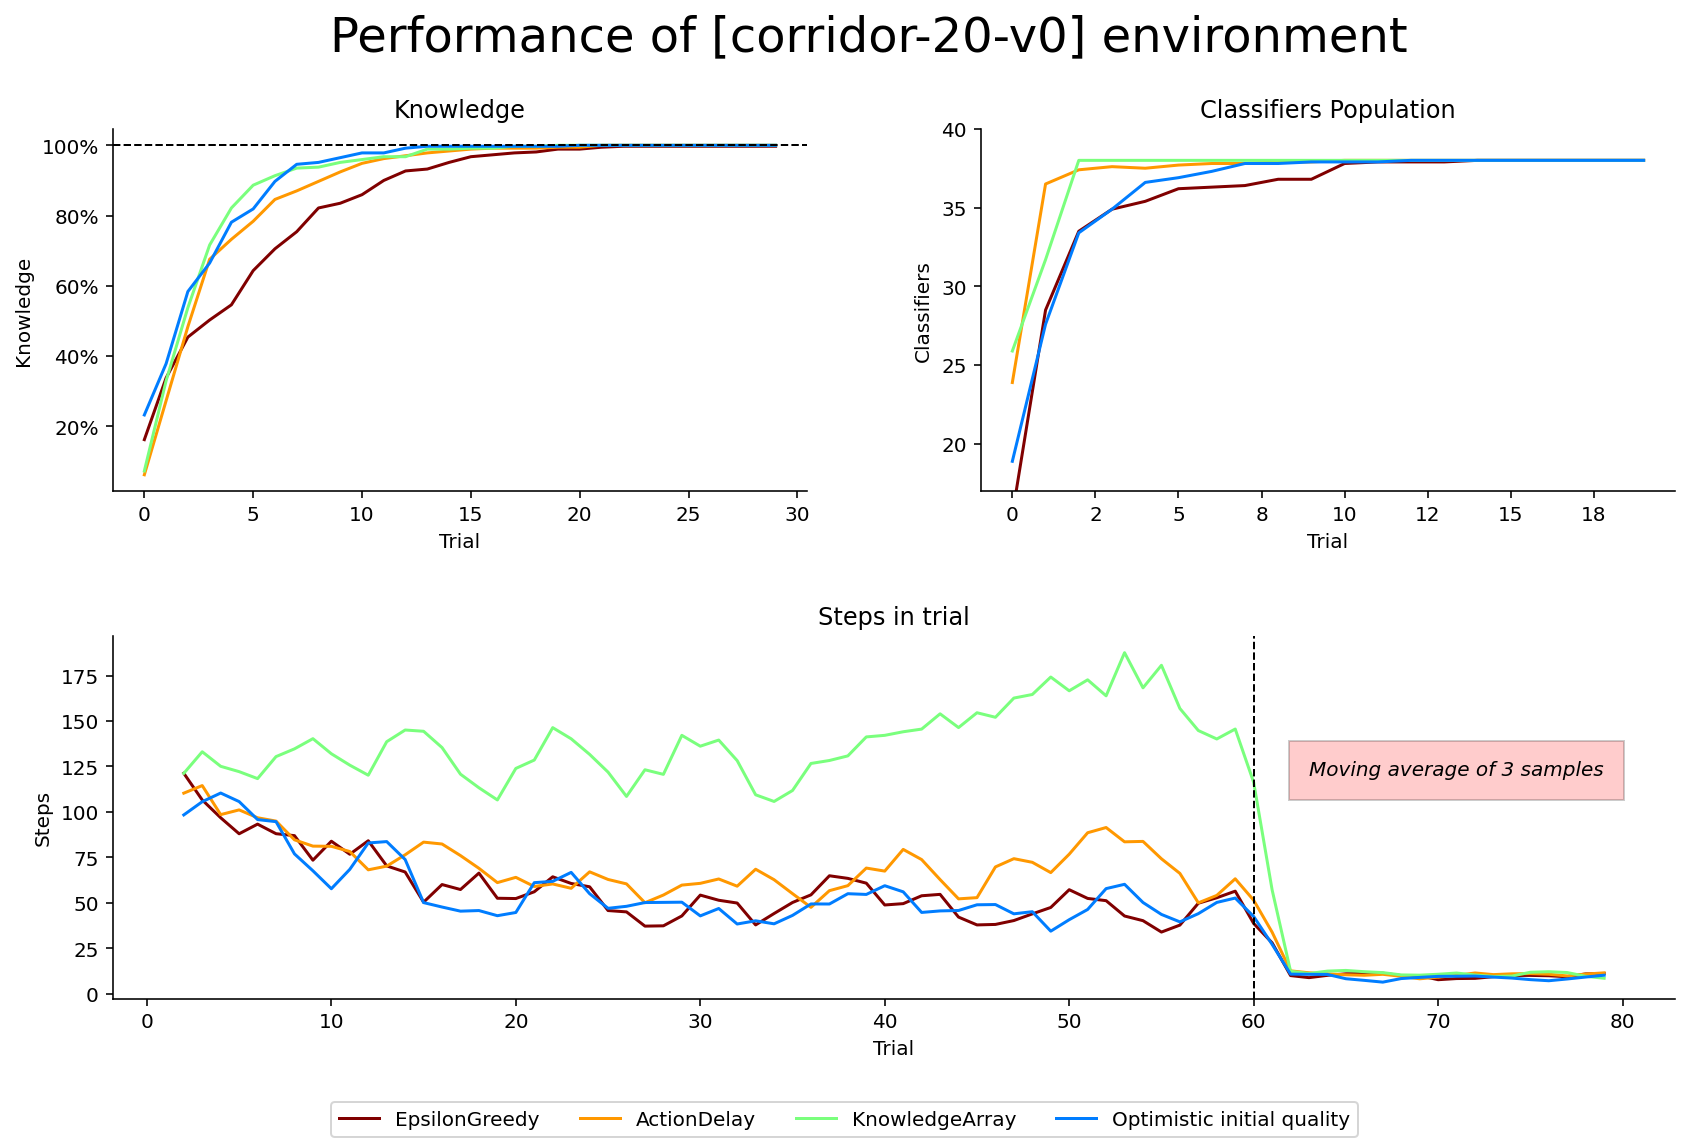

In [13]:
fig = plt.figure(figsize=(14, 8))

# Layout
gs = fig.add_gridspec(2,2, wspace=.25, hspace=.4)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

# Global title
fig.suptitle(f'Performance of [{env.unwrapped.spec.id}] environment', fontsize=24)

# Each axis

# Knowledge
ax1_first = 30  # number of first trials to show on plot

epsilon_greedy_df['knowledge'][:ax1_first].plot(label=epsilon_greedy_params['action_selector'].__name__, c=COLORS['eg'], ax=ax1)
action_delay_df['knowledge'][:ax1_first].plot(label=action_delay_params['action_selector'].__name__, c=COLORS['ad'], ax=ax1)
knowledge_array_df['knowledge'][:ax1_first].plot(label=knowledge_array_params['action_selector'].__name__, c=COLORS['ka'], ax=ax1)
op_initial_df['knowledge'][:ax1_first].plot(label='Optimistic initial quality', c=COLORS['oiq'], ax=ax1)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_title('Knowledge')
ax1.set_xlabel('Trial')
ax1.set_ylabel('Knowledge')
ax1.axhline(y=100, color='black', linewidth=1, linestyle="--")
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())


# Population
ax2_first = 20

epsilon_greedy_df['population'][:ax2_first].plot(label=epsilon_greedy_params['action_selector'].__name__, c=COLORS['eg'], ax=ax2)
action_delay_df['population'][:ax2_first].plot(label=action_delay_params['action_selector'].__name__, c=COLORS['ad'], ax=ax2)
knowledge_array_df['population'][:ax2_first].plot(label=knowledge_array_params['action_selector'].__name__, c=COLORS['ka'], ax=ax2)
op_initial_df['population'][:ax2_first].plot(label='Optimistic initial quality', c=COLORS['oiq'], ax=ax2)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel('Trial')
ax2.set_ylabel('Classifiers')
ax2.set_title('Classifiers Population')
ax2.set_ylim(17, 40)
ax2.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))
ax2.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f'))

# Steps in trial
window = 3 # window for moving average
epsilon_greedy_df['steps_in_trial'].rolling(window=window).mean().plot(label=epsilon_greedy_params['action_selector'].__name__, c=COLORS['eg'], ax=ax3)
action_delay_df['steps_in_trial'].rolling(window=window).mean().plot(label=action_delay_params['action_selector'].__name__, c=COLORS['ad'], ax=ax3)
knowledge_array_df['steps_in_trial'].rolling(window=window).mean().plot(label=knowledge_array_params['action_selector'].__name__, c=COLORS['ka'], ax=ax3)
op_initial_df['steps_in_trial'].rolling(window=window).mean().plot(label='Optimistic initial quality', c=COLORS['oiq'], ax=ax3)


ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.set_xlabel('Trial')
ax3.set_ylabel('Steps')
ax3.set_title('Steps in trial')
ax3.axvline(x=explore_trials, color='black', linewidth=1, linestyle="--")
ax3.text(63, 120, f'Moving average of {window} samples', style='italic', bbox={'facecolor': 'red', 'alpha': 0.2, 'pad': 10})

# Create legend
handles, labels = ax3.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4);

# Save plot to file
# fig.savefig('corridor-performance.pdf')
